# Enzo Rodrigues Novais Dias

# 1. Introdução e Justificativa do Problema
O Aprendizado Federado (FL) emergiu como um paradigma promissor para treinar modelos de machine learning em dados distribuídos, preservando a privacidade. O principal desafio nesta área é a heterogeneidade dos dados, ou distribuição Não-IID (Not Independent and Identically Distributed), onde os dados em cada cliente não são representativos da distribuição global.

Este trabalho foca no caso mais extremo desta condição, utilizando o dataset simulado 50-devices-unico-rotulo. Neste cenário, cada um dos mais de 50 clientes possui exclusivamente dados de uma única classe do MNIST (ex: um cliente só tem imagens do dígito '5', outro só do '1', etc.).

A questão central desta pesquisa é: **A falha de aprendizado em cenários de heterogeneidade extrema é causada por uma estrutura de dados inerentemente "impossível", ou pela limitação dos algoritmos padrão em lidar com a fragmentação dessa estrutura?**

Para responder a esta pergunta, realizamos dois experimentos sequenciais.

# 2. Experimento 1: Análise de Separabilidade dos Dados com Clusterização

## 2.1. Propósito e Hipótese
O objetivo deste primeiro experimento foi determinar se os dados do cenário 50-devices-unico-rotulo, quando vistos como um todo, ainda continham uma estrutura separável correspondente às 10 classes de dígitos originais.

A hipótese era: **se fornecermos a um algoritmo de clusterização (K-Means) a informação global correta (o número de classes k=10), ele será capaz de superar a distribuição fragmentada e identificar os 10 grupos de dígitos com sucesso.**

Foco do experimento: '50-devices-unico-rotulo'
Número de clusters (k) a ser encontrado: 10
Dados e rótulos carregados. Formato dos dados: (215488, 784)
Executando K-Means com k=10...
Clusterização concluída

 Avaliação da Clusterização:
Adjusted Rand Score (ARI): 0.3257

 Gerando visualização com t-SNE (usando amostragem)...


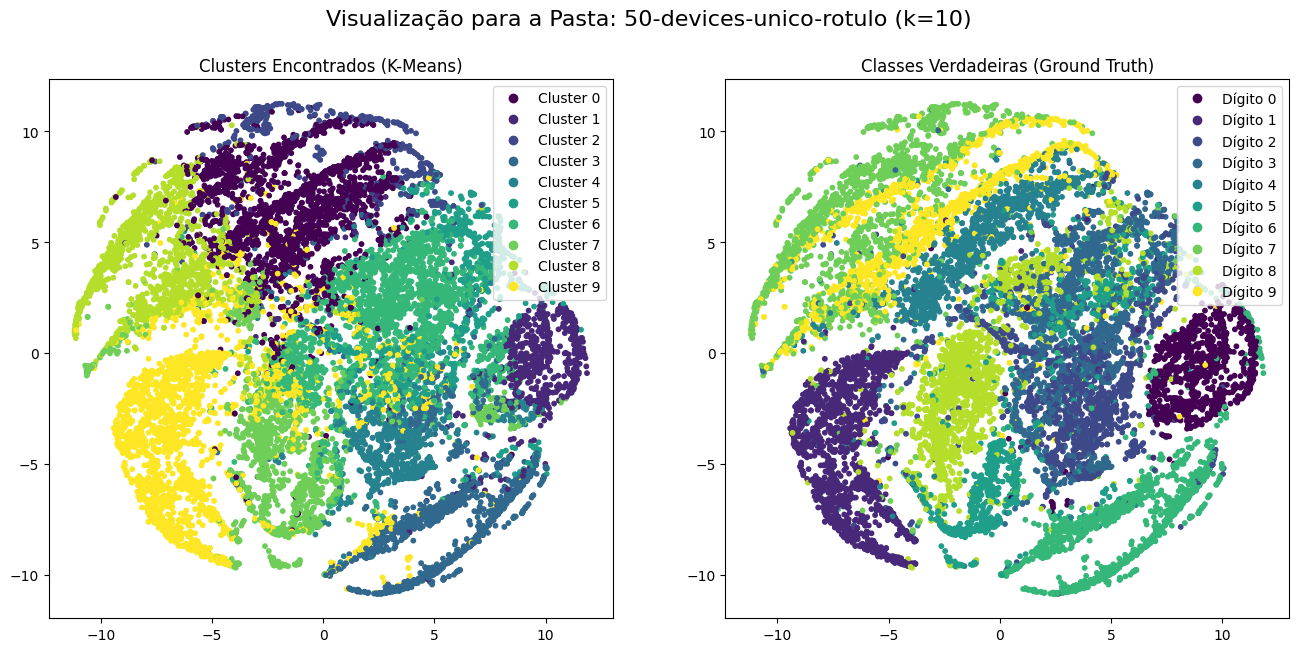

In [ ]:
import os, pickle, numpy as np, pandas as pd, warnings, glob
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
!unzip -q -o FL-cluster.zip

cenario_a_testar = '50-devices-unico-rotulo'
caminho_base = 'FL-cluster/dados/mnist/base'
caminho_cenario = os.path.join(caminho_base, cenario_a_testar)
print(f"Foco do experimento: '{cenario_a_testar}'")

k = 10
print(f"Número de clusters (k) a ser encontrado: {k}")

if not os.path.isdir(caminho_cenario):
    print(f"A pasta do cenário não foi encontrada.")
else:
    pickle_files = glob.glob(os.path.join(caminho_cenario, '*.pickle'))
    all_data_from_pickles = [pickle.load(open(file_path, 'rb')) for file_path in pickle_files]
    full_dataset = pd.concat(all_data_from_pickles, ignore_index=True).to_numpy()
    X_folder, true_labels = full_dataset[:, :-1], full_dataset[:, -1]

    print(f"Dados e rótulos carregados. Formato dos dados: {X_folder.shape}")

    X_folder_scaled = StandardScaler().fit_transform(X_folder)

    print(f"Executando K-Means com k={k}...")
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_folder_scaled)
    print(f"Clusterização concluída")

    print(f"\n Avaliação da Clusterização:")
    ari_score = metrics.adjusted_rand_score(true_labels, clusters)
    print(f"Adjusted Rand Score (ARI): {ari_score:.4f}")

    print("\n Gerando visualização com t-SNE (usando amostragem)...")
    n_samples = 15000
    idx = np.random.choice(X_folder.shape[0], n_samples, replace=False) if X_folder.shape[0] > n_samples else np.arange(X_folder.shape[0])
    X_sample, labels_sample, clusters_sample = X_folder_scaled[idx, :], true_labels[idx], clusters[idx]

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    X_2d = tsne.fit_transform(X_sample)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Visualização para a Pasta: {cenario_a_testar} (k={k})', fontsize=16)
    scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=clusters_sample, cmap='viridis', s=10)
    axes[0].set_title('Clusters Encontrados (K-Means)')
    axes[0].legend(handles=scatter1.legend_elements(num=k)[0], labels=[f'Cluster {i}' for i in range(k)])

    unique_labels = np.unique(labels_sample)
    scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_sample, cmap='viridis', s=10)
    axes[1].set_title('Classes Verdadeiras (Ground Truth)')
    axes[1].legend(handles=scatter2.legend_elements(num=len(unique_labels))[0], labels=[f'Dígito {int(l)}' for l in unique_labels])
    plt.show()

## 2.2. Análise dos Resultados
Resultado Quantitativo: Adjusted Rand Score (ARI): 0.3257

O score ARI de 0.326 é quase idêntico ao do nosso baseline de dados centralizados (0.323), indicando uma alta qualidade de clusterização. A visualização confirma isso, mostrando uma forte correspondência entre os clusters encontrados pelo K-Means (gráfico da esquerda) e as classes verdadeiras dos dígitos (gráfico da direita).

Conclusão do Experimento 1: A hipótese foi confirmada. A estrutura de dados, embora fragmentada, é inerentemente separável. A falha em análises anteriores não se devia a um problema intratável nos dados, mas sim a uma premissa incorreta sobre sua estrutura (usar k=2). Isso isola o problema: não é a separabilidade dos dados, mas potencialmente a capacidade dos algoritmos de aprendizado de lidar com essa separação.

# 3. Experimento 2: Teste de Robustez do Aprendizado Colaborativo

## 3.1. Propósito e Hipótese
Com a prova de que uma solução global de alta qualidade existe, o segundo experimento testou se um algoritmo de aprendizado colaborativo padrão (FedAvg) conseguiria convergir para essa solução.

A hipótese era: mesmo sabendo que os dados são separáveis, o FedAvg falhará, pois o "client drift" (a tendência de cada modelo local se especializar em seus dados enviesados) será tão extremo que a agregação por média no servidor será ineficaz.


Iniciando experimento: 50-devices-unico-rotulo
---> Rodada 1/15 (LR: 0.00100)
   ===> Acurácia Global: 0.0991
---> Rodada 2/15 (LR: 0.00098)
   ===> Acurácia Global: 0.0958
---> Rodada 3/15 (LR: 0.00096)
   ===> Acurácia Global: 0.1100
---> Rodada 4/15 (LR: 0.00094)
   ===> Acurácia Global: 0.0892
---> Rodada 5/15 (LR: 0.00092)
   ===> Acurácia Global: 0.1162
---> Rodada 6/15 (LR: 0.00090)
   ===> Acurácia Global: 0.1015
---> Rodada 7/15 (LR: 0.00089)
   ===> Acurácia Global: 0.1010
---> Rodada 8/15 (LR: 0.00087)
   ===> Acurácia Global: 0.1009
---> Rodada 9/15 (LR: 0.00085)
   ===> Acurácia Global: 0.0958
---> Rodada 10/15 (LR: 0.00083)
   ===> Acurácia Global: 0.1365
---> Rodada 11/15 (LR: 0.00082)
   ===> Acurácia Global: 0.1028
---> Rodada 12/15 (LR: 0.00080)
   ===> Acurácia Global: 0.1009
---> Rodada 13/15 (LR: 0.00078)
   ===> Acurácia Global: 0.0982
---> Rodada 14/15 (LR: 0.00077)
   ===> Acurácia Global: 0.1104
---> Rodada 15/15 (LR: 0.00075)
   ===> Acurácia Global: 0.1163
E

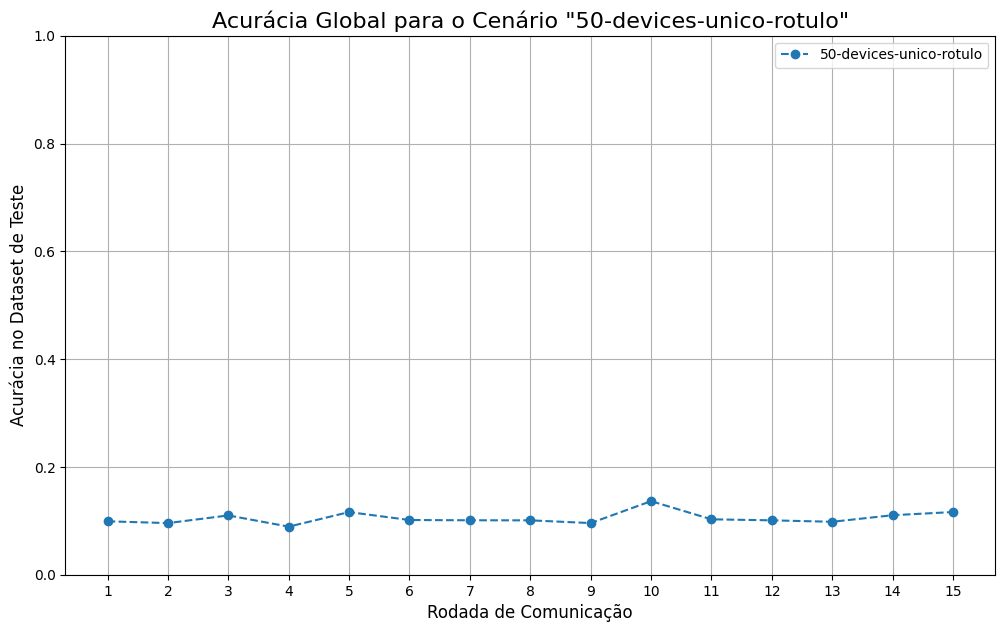

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import glob
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def carregar_dados_dos_clientes(caminho_pasta_cenario):
    clientes = []
    arquivos_pickle = glob.glob(os.path.join(caminho_pasta_cenario, '*.pickle'))
    for arquivo in arquivos_pickle:
        with open(arquivo, 'rb') as f:
            df_cliente = pickle.load(f)
        X = df_cliente.iloc[:, :-1].to_numpy().reshape(-1, 28, 28, 1).astype('float32') / 255.0
        y = df_cliente.iloc[:, -1].to_numpy()
        clientes.append({'X': X, 'y': y})
    return clientes

def carregar_dados_de_teste_centralizados(caminho_arquivo_teste):
    with open(caminho_arquivo_teste, 'rb') as f:
        df_teste = pickle.load(f)
    np_teste = df_teste.to_numpy()
    X_teste = np_teste[:, :-1].reshape(-1, 28, 28, 1).astype('float32') / 255.0
    y_teste = np_teste[:, -1]
    return X_teste, y_teste

def criar_modelo_cnn():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def media_federada_dos_pesos(lista_de_pesos):
    novos_pesos = list()
    for i in range(len(lista_de_pesos[0])):
        pesos_da_camada_i = np.array([cliente[i] for cliente in lista_de_pesos])
        media_pesos_camada_i = np.mean(pesos_da_camada_i, axis=0)
        novos_pesos.append(media_pesos_camada_i)
    return novos_pesos

!unzip -q -o FL-cluster.zip
caminho_base = 'FL-cluster/dados/mnist/base'
caminho_teste = os.path.join(caminho_base, 'mnist/test.pickle')
X_teste_global, y_teste_global = carregar_dados_de_teste_centralizados(caminho_teste)

cenarios_a_testar = [
    '50-devices-unico-rotulo'
]

RODADAS_DE_COMUNICACAO = 15
CLIENTES_POR_RODADA = 20
EPOCHS_LOCAIS = 5
BATCH_SIZE = 32
TAXA_APRENDIZADO_INICIAL = 0.001
FATOR_DECAIMENTO_LR = 0.98

historicos_de_acuracia = {}

for cenario in cenarios_a_testar:
    print(f"\n{'='*50}")
    print(f"Iniciando experimento: {cenario}")
    print(f"{'='*50}")

    caminho_cenario = os.path.join(caminho_base, cenario)
    dados_clientes = carregar_dados_dos_clientes(caminho_cenario)

    modelo_global = criar_modelo_cnn()
    historico_cenario_atual = []
    taxa_aprendizado_atual = TAXA_APRENDIZADO_INICIAL

    for rodada in range(RODADAS_DE_COMUNICACAO):
        print(f"---> Rodada {rodada + 1}/{RODADAS_DE_COMUNICACAO} (LR: {taxa_aprendizado_atual:.5f})")

        modelo_global.compile(
            optimizer=keras.optimizers.Adam(learning_rate=taxa_aprendizado_atual),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        pesos_globais = modelo_global.get_weights()
        clientes_selecionados = random.sample(dados_clientes, CLIENTES_POR_RODADA)
        lista_pesos_locais = []

        for cliente in clientes_selecionados:
            modelo_local = criar_modelo_cnn()
            modelo_local.compile(
                optimizer=keras.optimizers.Adam(learning_rate=taxa_aprendizado_atual),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
            modelo_local.set_weights(pesos_globais)
            modelo_local.fit(cliente['X'], cliente['y'], epochs=EPOCHS_LOCAIS, batch_size=BATCH_SIZE, verbose=0)
            lista_pesos_locais.append(modelo_local.get_weights())

        if lista_pesos_locais:
            novos_pesos_globais = media_federada_dos_pesos(lista_pesos_locais)
            modelo_global.set_weights(novos_pesos_globais)

        loss, accuracy = modelo_global.evaluate(X_teste_global, y_teste_global, verbose=0)
        historico_cenario_atual.append(accuracy)
        print(f"   ===> Acurácia Global: {accuracy:.4f}")

        taxa_aprendizado_atual *= FATOR_DECAIMENTO_LR

    historicos_de_acuracia[cenario] = historico_cenario_atual
    print(f"Experimento para '{cenario}' concluído")

plt.figure(figsize=(12, 7))
for cenario, historico in historicos_de_acuracia.items():
    plt.plot(range(1, len(historico) + 1), historico, marker='o', linestyle='--', label=cenario)

plt.title(f'Acurácia Global para o Cenário "{cenarios_a_testar[0]}"', fontsize=16)
plt.xlabel('Rodada de Comunicação', fontsize=12)
plt.ylabel('Acurácia no Dataset de Teste', fontsize=12)
plt.xticks(range(1, RODADAS_DE_COMUNICACAO + 1))
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()

## 3.2. Análise dos Resultados
Resultado Quantitativo: A acurácia global final foi de 11.6%, sem apresentar melhora significativa ao longo das 15 rodadas.

O resultado foi uma falha. Conforme a hipótese, o modelo não aprendeu. A curva de acurácia permaneceu estagnada em um nível equivalente ao de um classificador aleatório. O "client drift" foi máximo: cada cliente otimizou seu modelo para reconhecer apenas um dígito, e ao fazer a média desses dez "ultra-especialistas", o modelo global resultante se tornou confuso e sem nenhum conhecimento generalizável.

# 4. Conclusão Geral e Implicações
A justaposição dos dois experimentos fornece uma conclusão:

O desafio fundamental em cenários de heterogeneidade extrema, como o 50-devices-unico-rotulo, não é a separabilidade dos dados, mas a capacidade do algoritmo de aprendizado de navegar pela distribuição fragmentada para encontrar a solução global.

O trabalho demonstrou que um algoritmo com visão global (K-Means com o k correto) pode ter sucesso, enquanto um algoritmo colaborativo com visão local (FedAvg) falha catastroficamente. Isso valida empiricamente por que o FedAvg é insuficiente para muitos cenários do mundo real e motiva diretamente a necessidade de algoritmos de Aprendizado Federado de segunda geração.

Próximos Passos para a Pesquisa:
O próximo passo lógico para esta pesquisa é implementar um algoritmo projetado para combater o "client drift", como o FedProx. A hipótese seria que o FedProx, ao forçar os modelos locais a permanecerem mais próximos do modelo global, conseguiria superar a barreira da heterogeneidade e alcançar uma acurácia significativamente maior que o FedAvg neste mesmo cenário desafiador.